In [1]:
from droidlet.perception.robot import LabelPropagate
import os
import json
import sys
if "/opt/ros/kinetic/lib/python2.7/dist-packages" in sys.path:
    sys.path.remove("/opt/ros/kinetic/lib/python2.7/dist-packages")
import cv2
import numpy as np

/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [13]:
root = '/checkpoint/apratik/finals/default/apartment_0/'

def make_data(root, img_indx):
    src_img = cv2.imread(os.path.join(root, "rgb/{:05d}.jpg".format(img_indx)))
    src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
    src_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx)))
    with open(os.path.join(root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]
    cur_pose = base_pose_data["{}".format(img_indx+1)]
    cur_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx+1)))
    print(f'{type(src_img), type(src_depth), type(src_label)}')
    # Visualize label
    return src_img, src_depth, src_label, src_pose, cur_pose, cur_depth
    
src_img, src_depth, src_label, src_pose, cur_pose, cur_depth = make_data(root, 1)

(<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


In [14]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

from utils import d3_40_colors_rgb

def display_sample(semantic1, semantic2):
    
    arr = []
    for semantic_obs in [semantic1, semantic2]:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)

    titles = ['src', 'propagated']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 2, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

In [15]:
x = LabelPropagate()

In [16]:
label = x(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

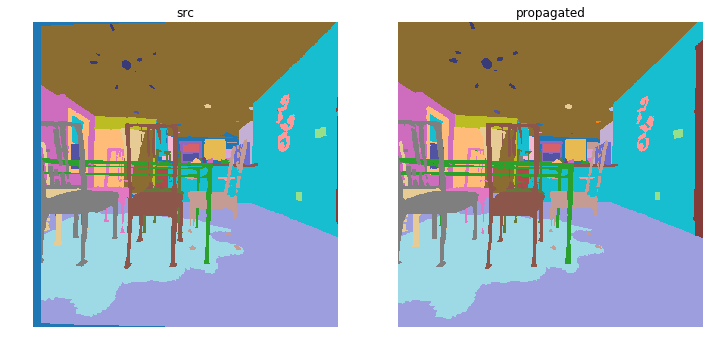

In [17]:
display_sample(label, src_label)